# Data Analysis 2 - Assignment 1 
Péter Szilvási

Máté Schieszler

---
#  Setting up Environment and Dataset
--- 

In [1]:
# import necessary libraries
import pandas as pd
import os
import sys
import warnings
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import plotly.express as px
from plotnine import *
from mizani.formatters import percent_format
import matplotlib.pyplot as plt

from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss


warnings.filterwarnings("ignore")

--- 
## Importing our dataset
--- 

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("DA2_2023")[0]

# Load prewritten functions
func = dirname + "DA2_2023/work-files/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# import Prices and Features CSVs
prices = pd.read_csv("https://raw.githubusercontent.com/mateschieszler/DA2_2023/main/work-files/assignment2/hotels-europe_price.csv")
features = pd.read_csv("https://raw.githubusercontent.com/mateschieszler/DA2_2023/main/work-files/assignment2/hotels-europe_features.csv")

In [5]:
# Merge tables using hotel_id
df = prices.merge(features, on ="hotel_id")
df['hotel_id'].unique().shape[0]

22902

In [6]:
# deciding on a good city to analyze
df.groupby('city').agg({'hotel_id': 'nunique'}).sort_values('hotel_id', ascending=False).head(5)


,hotel_id
city,
Rome,4883
Paris,2184
London,1401
Istanbul,1377
Milan,1098


In [7]:
df_milan = df.loc[df['city']=="Milan"]
f"Before filtering we have {df_milan['hotel_id'].unique().shape[0]} hotels in Milan."

'Before filtering we have 1098 hotels in Milan.'

--- 
## Initial look at our data
    - creating highly_rated binary column
--- 

In [8]:
df_milan.T

,69900,69901,69902,69903,69904,69905,69906,69907,69908,69909,...,77170,77171,77172,77173,77174,77175,77176,77177,77178,77179
hotel_id,9797,9797,9798,9798,9798,9798,9798,9798,9798,9798,...,10893,10893,10893,10894,10894,10894,10894,10894,10894,10894
price,66,66,61,63,63,246,58,103,58,58,...,66,66,66,81,81,274,129,70,70,70
offer,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,1,1,1
offer_cat,0% no offer,0% no offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,0% no offer,15-50% offer,15-50% offer,...,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,0% no offer,15-50% offer,15-50% offer,15-50% offer
year,2017,2017,2017,2018,2018,2017,2018,2017,2018,2018,...,2018,2018,2018,2018,2018,2017,2017,2017,2017,2018
month,11,11,12,1,3,12,6,11,4,5,...,5,4,2,3,2,12,11,12,11,1
weekend,1,0,0,1,1,0,1,0,1,1,...,1,1,1,1,1,0,0,0,1,1
holiday,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
nnights,1,1,1,1,1,4,1,1,1,1,...,1,1,1,1,1,4,1,1,1,1
scarce_room,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0


In [9]:
df_milan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7280 entries, 69900 to 77179
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hotel_id            7280 non-null   int64  
 1   price               7280 non-null   int64  
 2   offer               7280 non-null   int64  
 3   offer_cat           7280 non-null   object 
 4   year                7280 non-null   int64  
 5   month               7280 non-null   int64  
 6   weekend             7280 non-null   int64  
 7   holiday             7280 non-null   int64  
 8   nnights             7280 non-null   int64  
 9   scarce_room         7280 non-null   int64  
 10  city                7280 non-null   object 
 11  distance            7280 non-null   float64
 12  stars               4368 non-null   float64
 13  rating              6232 non-null   float64
 14  country             7280 non-null   object 
 15  city_actual         7280 non-null   object 
 16  r

In [10]:
# look at our df
df_milan.columns

Index(['hotel_id', 'price', 'offer', 'offer_cat', 'year', 'month', 'weekend',
       'holiday', 'nnights', 'scarce_room', 'city', 'distance', 'stars',
       'rating', 'country', 'city_actual', 'rating_reviewcount',
       'center1label', 'center2label', 'neighbourhood', 'ratingta',
       'ratingta_count', 'distance_alter', 'accommodation_type'],
      dtype='object')

In [11]:
# use hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise
df_milan['highly_rated'] = [1 if r >= 4 else 0 for r in df_milan['rating']]
# note drop those later where rating is missing

In [12]:
df_milan['highly_rated'].value_counts()

0    3712
1    3568
Name: highly_rated, dtype: int64

In [13]:
f'There are {df_milan["hotel_id"].nunique()} uniqe hotels in this table.'

'There are 1098 uniqe hotels in this table.'

---
#  1. Data Exploring 
--- 

## Checking Null values
---

In [14]:
# Check for null values in the rating column
print(f'''There are {df_milan["rating"].shape[0]} values in the `rating` column out of which {df_milan["rating"].isnull().sum()} are null.      
We have {df_milan["rating"].count()} non-empty cells.''')

There are 7280 values in the `rating` column out of which 1048 are null.      
We have 6232 non-empty cells.


In [15]:
# dropping nulls in the rating as it would give us 0 for highly_rated and might cause bias in our model
df_milan.dropna(subset=['rating'], inplace=True)
print(f'We have {df_milan["rating"].isnull().sum()} non-empty cells left. There are {df_milan["hotel_id"].nunique()} uniqe hotels left in this table.')

We have 0 non-empty cells left. There are 871 uniqe hotels left in this table.


In [16]:
null_count = df_milan['stars'].isnull().sum()
print(f"Number of null values in the 'stars' column: {null_count}")

Number of null values in the 'stars' column: 1890


In [17]:
df_milan.dropna(subset=['stars'], inplace=True)

In [18]:
f"We have in the end {df_milan['hotel_id'].unique().shape[0]} hotels to do our analysis on"

'We have in the end 537 hotels to do our analysis on'

In [19]:
# Check for null values for distance column
f"We have {df_milan['distance'].isnull().sum()} missing values for the distance column"

'We have 0 missing values for the distance column'

--- 
## Price Filtering
--- 

In [20]:
# Check for null values
df_milan['price'].isnull().sum()

0

<Axes: title={'center': 'Fig1: Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

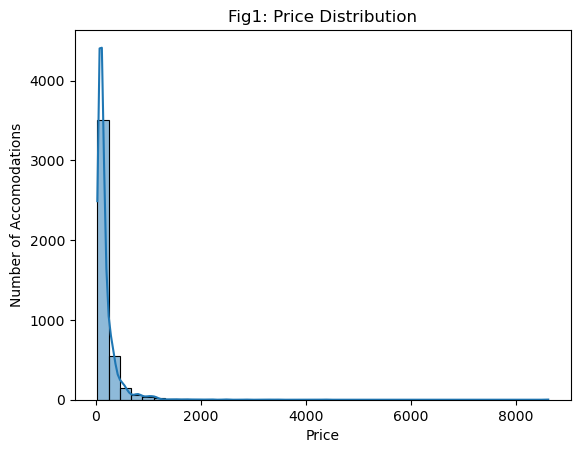

In [21]:
# Make a hist of the prices from the raw data
fig1 = sns.histplot(df_milan['price'],bins=40 ,kde=True)
fig1.set(title='Fig1: Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig1

In [22]:
# Get an idea about outliers
df_milan['price'].describe(percentiles=[0.5,0.95])

count    4342.000000
mean      187.476969
std       259.741031
min        32.000000
50%       110.000000
95%       542.950000
max      8617.000000
Name: price, dtype: float64

In [23]:
# filter out outliers, which are probably errors or luxury hotels
filtered_milan = df_milan.loc[df_milan['price'] <= 550]

<Axes: title={'center': 'Fig2: Filtered Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

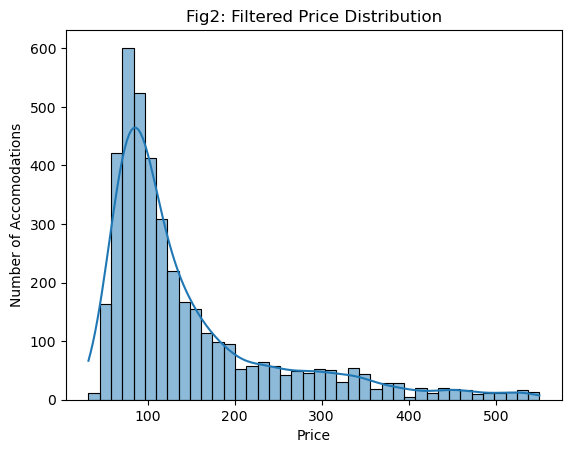

In [24]:
# Make a hist of the prices without outliers
fig2 = sns.histplot(filtered_milan['price'],bins=40 ,kde=True)
fig2.set(title='Fig2: Filtered Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig2

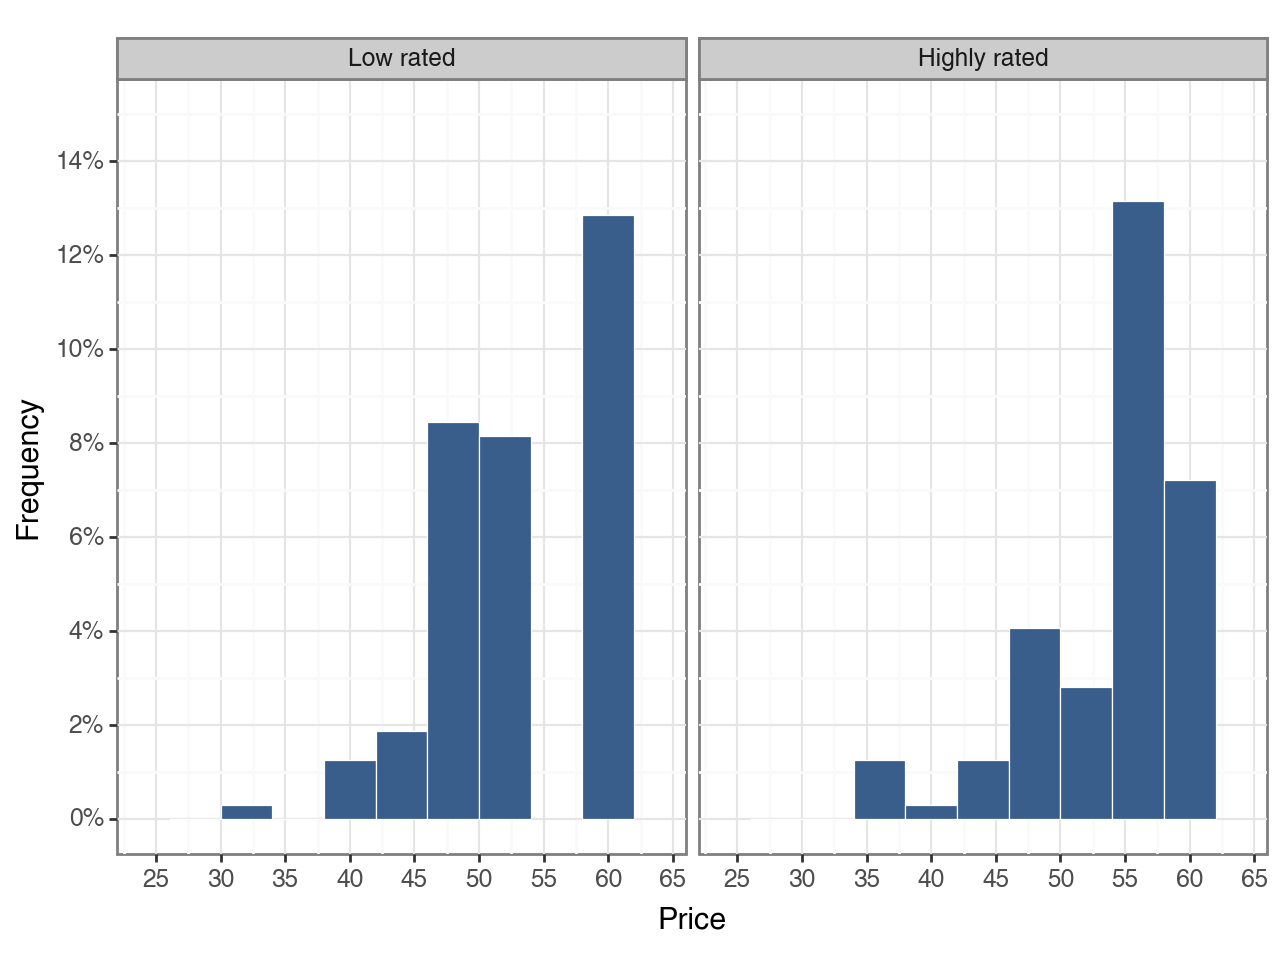

<Figure Size: (640 x 480)>

In [25]:
# Plot Price Distribution seperately for high and low rated
(
    ggplot(filtered_milan, aes(x="price", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
    )
    + facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"})
    + labs(x="Price", y="Frequency")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)

## Distance filtering

<Axes: title={'center': 'Fig4: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

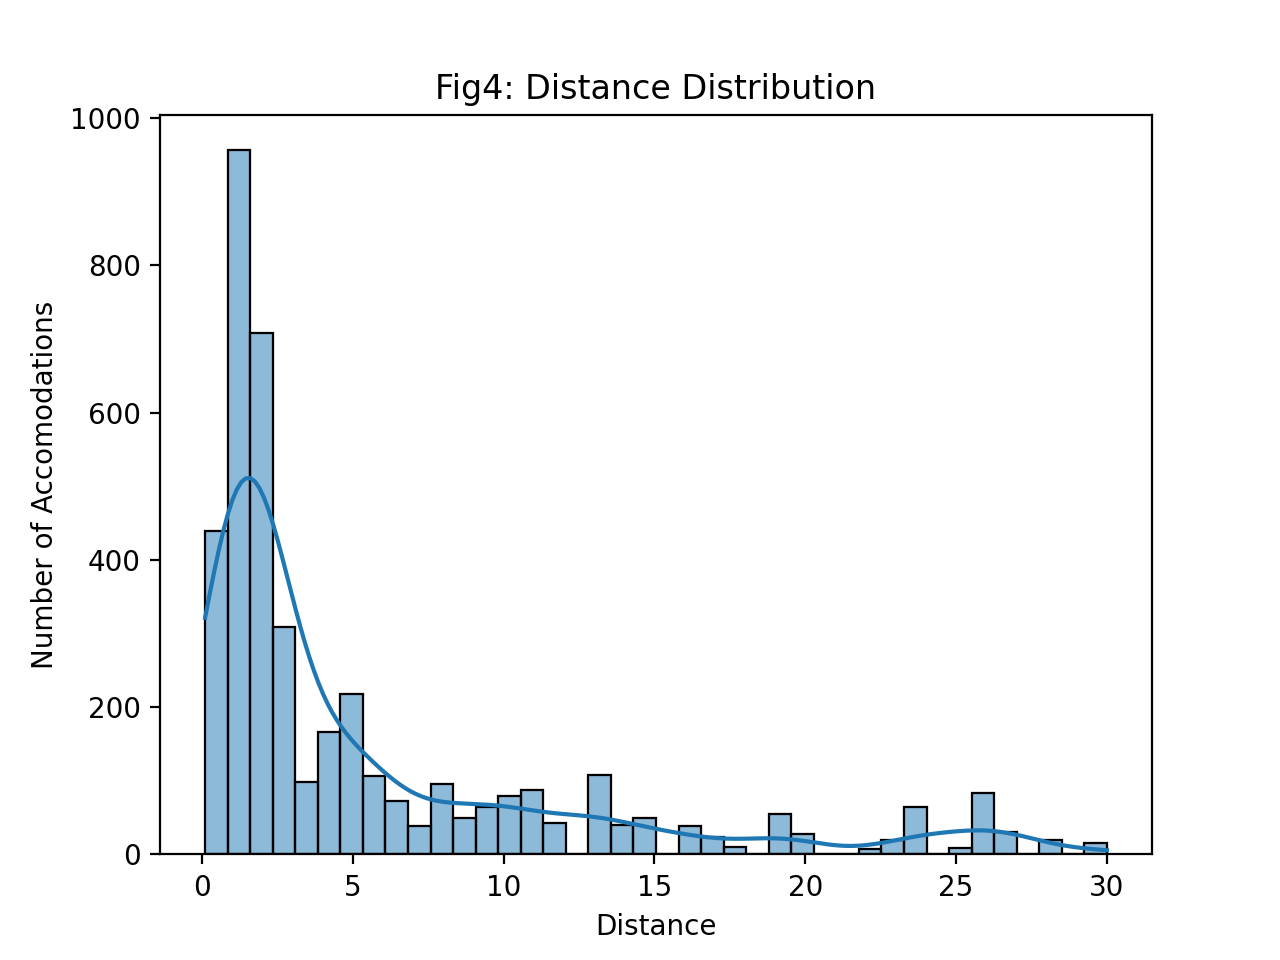

In [26]:
# Make a hist of the distance from the price filtered data
fig4 = sns.histplot(filtered_milan['distance'],bins=40 ,kde=True)
fig4.set(title='Fig4: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig4

In [27]:
# Get an idea about outliers
filtered_milan['distance'].describe(percentiles=[0.5,0.95])

count    4134.000000
mean        5.566086
std         6.773454
min         0.100000
50%         2.200000
95%        24.000000
max        30.000000
Name: distance, dtype: float64

In [28]:
# filter out outliers, which are probably errors (very far from city centre)
filtered_milan = filtered_milan.loc[filtered_milan['distance'] <= 10] # 10 km becasue it covers all the city. We looked at map, and we are only interested in Milan itself. 
print(f"We still have {filtered_milan['hotel_id'].unique().shape[0]} uniqe hotels in this table.")

We still have 439 uniqe hotels in this table.


<Axes: title={'center': 'Fig5: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

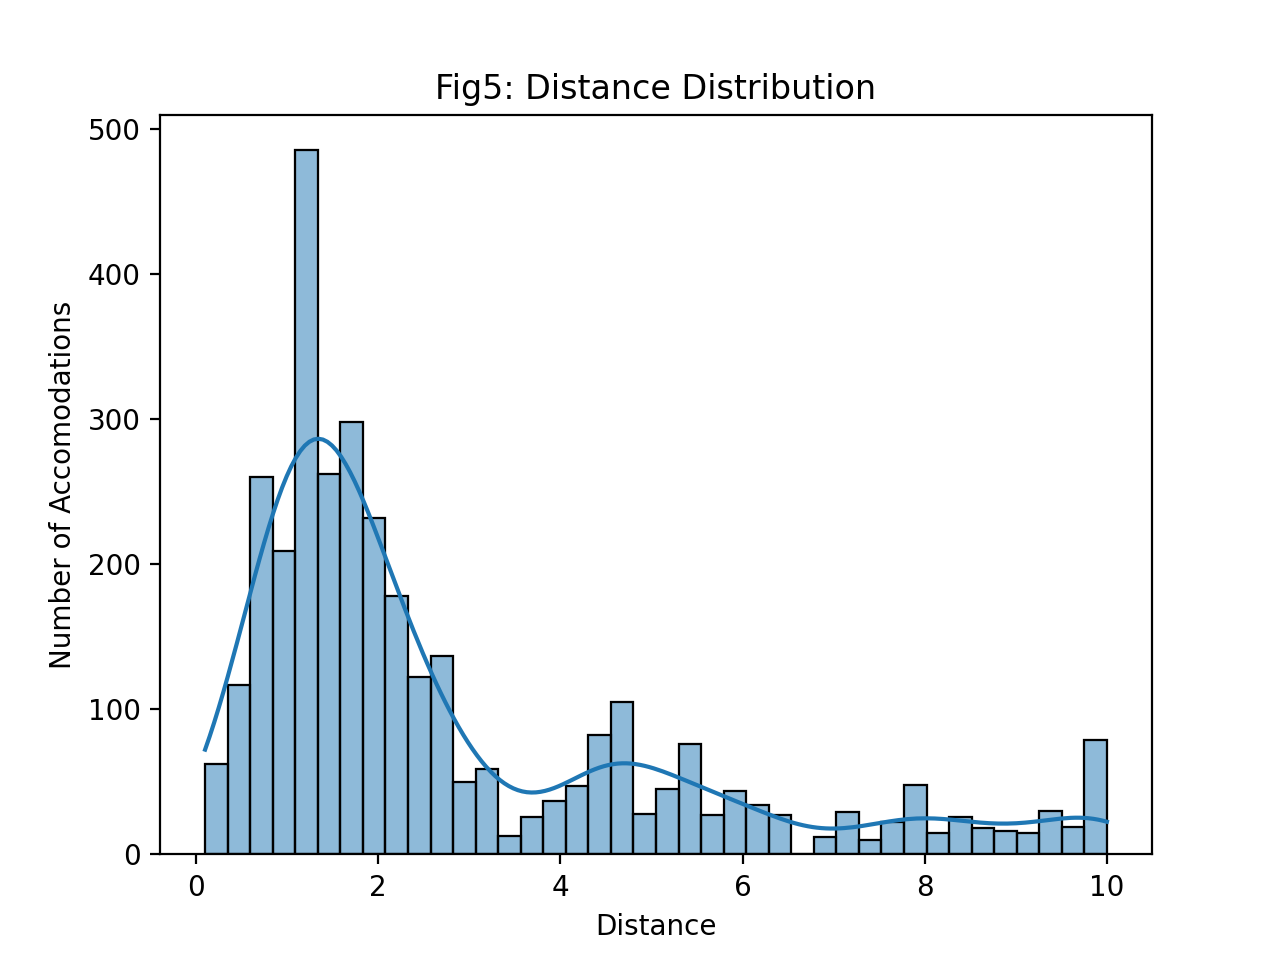

In [29]:
# Make a hist of the distance from the filtered data
fig5 = sns.histplot(filtered_milan['distance'],bins=40 ,kde=True)
fig5.set(title='Fig5: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig5

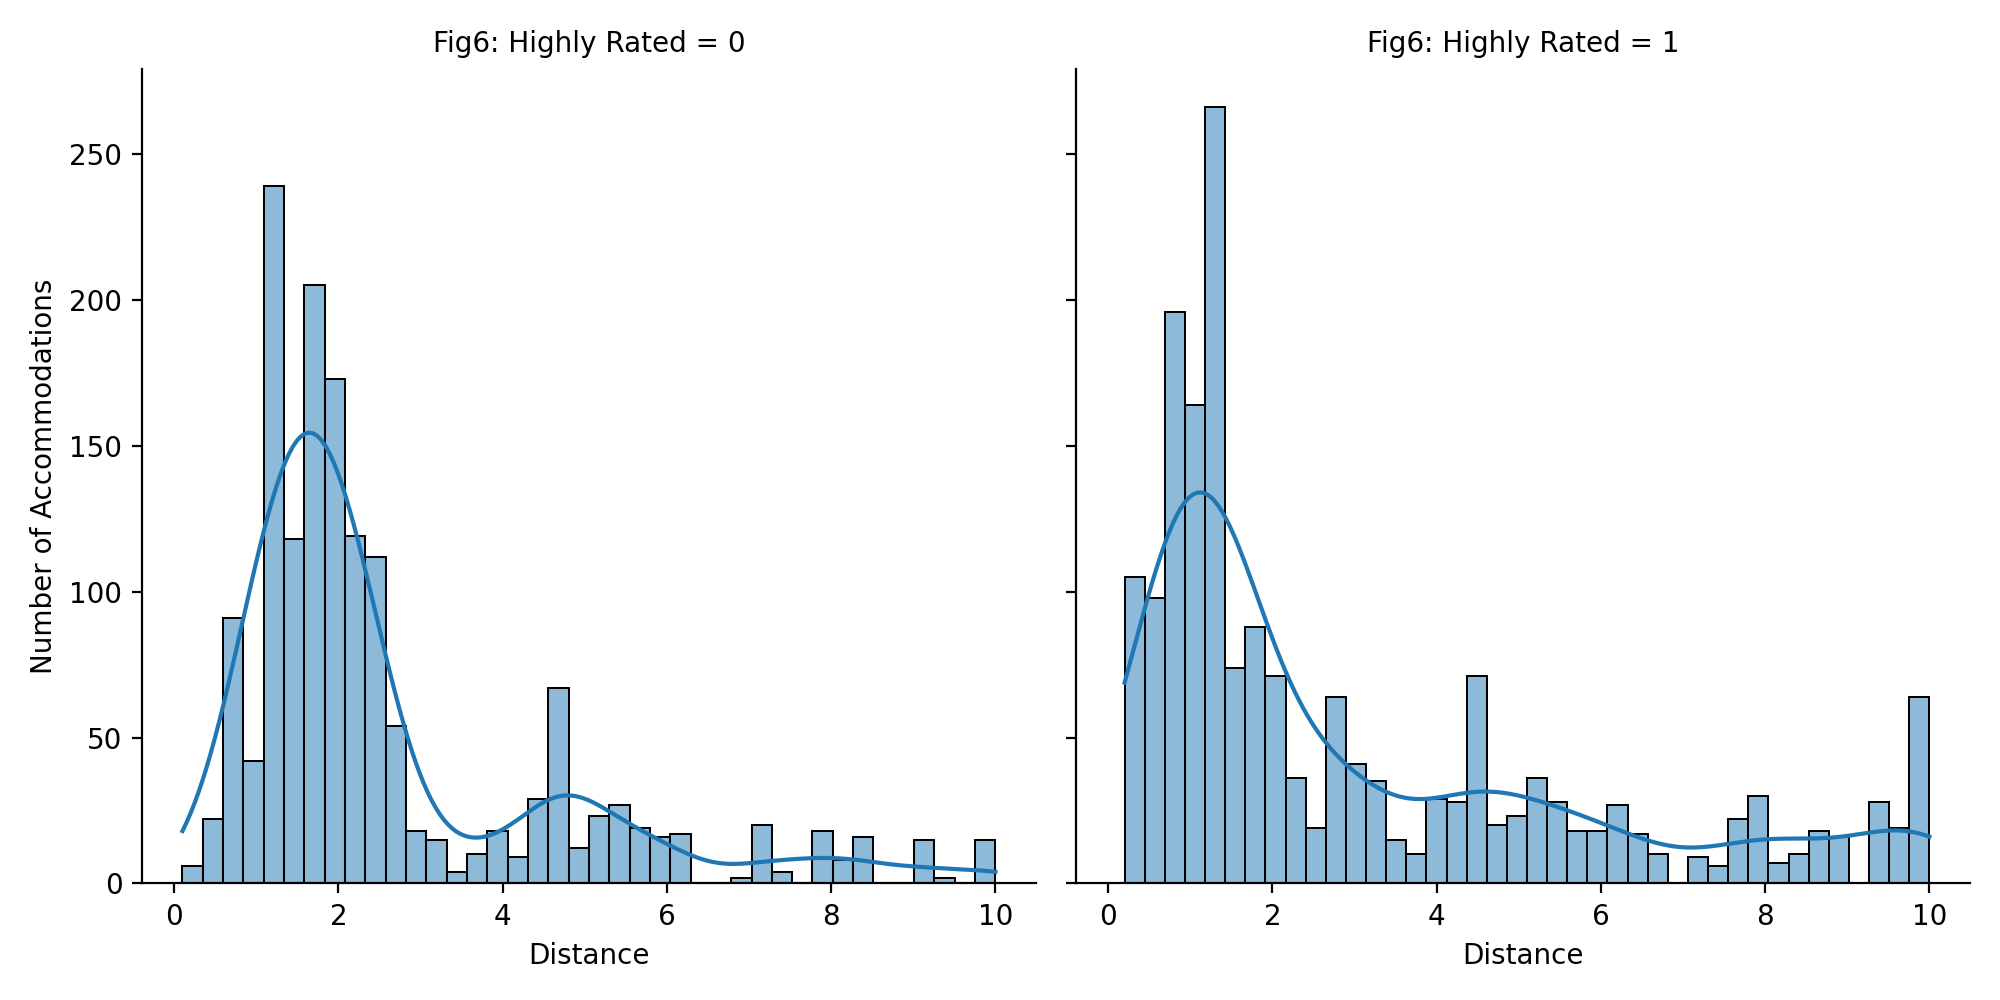

In [30]:
# Create a FacetGrid in sns to see distribution of distance for highly rated and low rated
grid = sns.FacetGrid(filtered_milan, col='highly_rated', height=5)
grid.map(sns.histplot, 'distance', bins=40, kde=True)

grid.set_titles(col_template='Fig6: Highly Rated = {col_name}')
grid.set_axis_labels(x_var='Distance', y_var='Number of Accommodations')

plt.show()

## Stars filtering

In [31]:
filtered_milan['stars'].value_counts().reset_index().sort_values(by='index') # we dropped them before

,index,stars
3,1.0,177
2,2.0,293
1,3.0,1078
5,3.5,10
0,4.0,1707
4,5.0,136


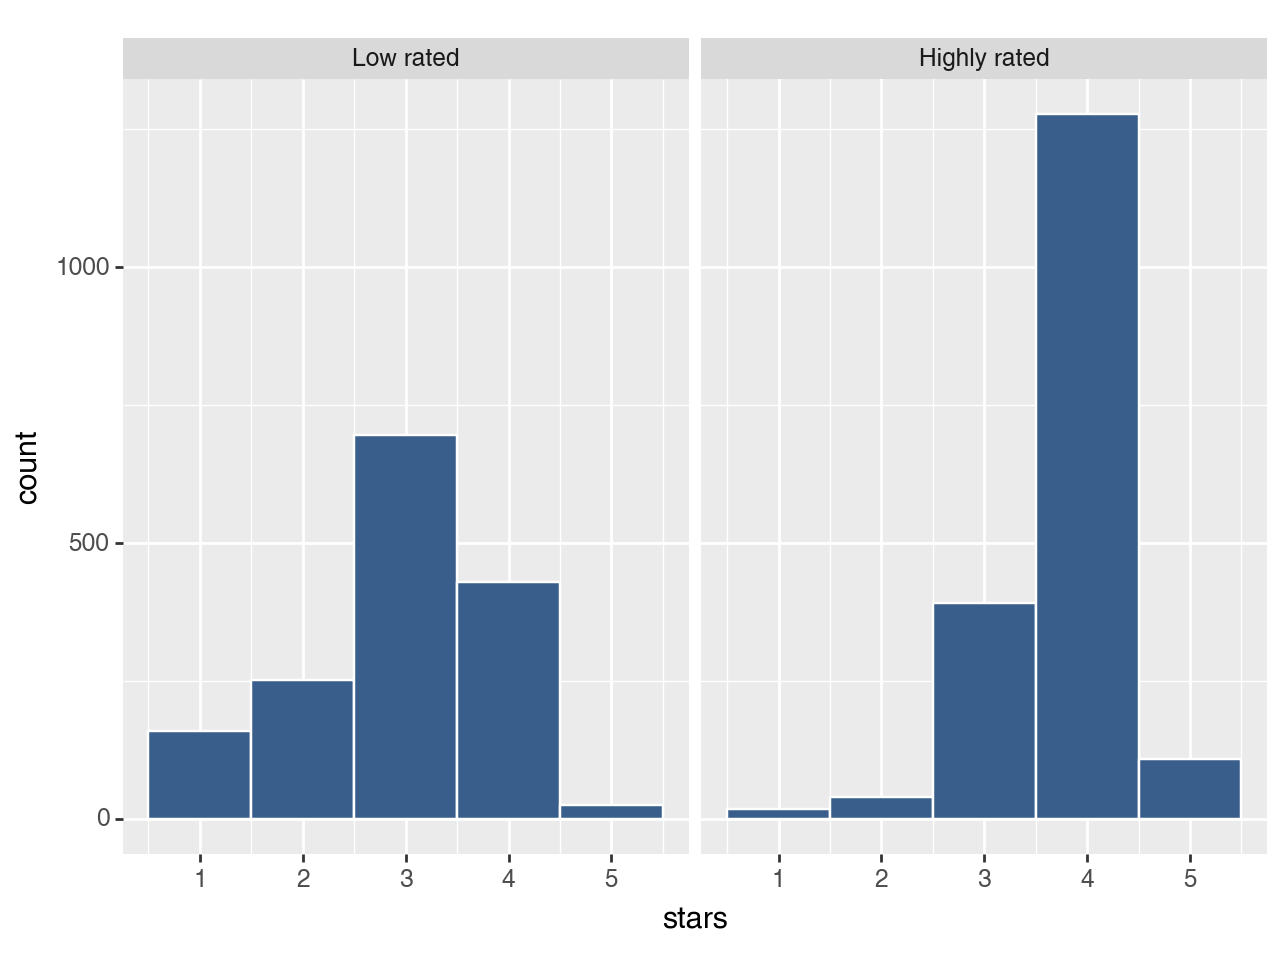

<Figure Size: (640 x 480)>

In [32]:
# Plot the distribution of stars
(ggplot(filtered_milan, aes(x="stars"))
 + geom_histogram(
     binwidth=1,
        color="white",
        fill=color[0])
+ facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"}))

In [33]:
# No filtering in this column

--- 
#### We examine 2 lowess regressions to decide what functional forms to include

- highly rated and price 
- highly rated and distance
--- 

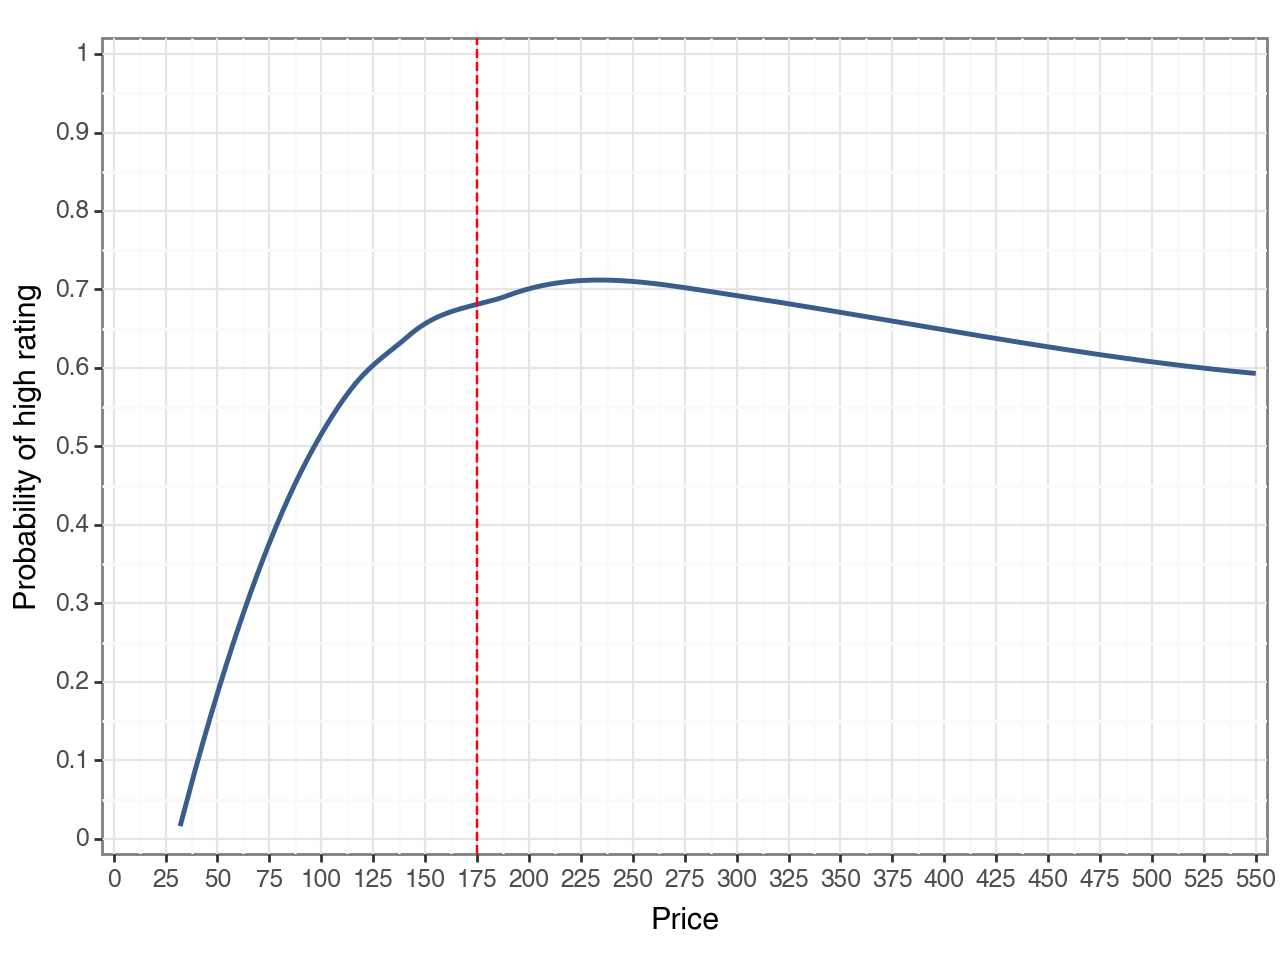

<Figure Size: (640 x 480)>

In [34]:
g2a = (
    ggplot(data=filtered_milan)
    + geom_smooth(
        aes(x="price", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Price ", y="Probability of high rating "
    )
    + geom_vline(xintercept=175, linetype="dashed", color="red")  # Add vertical line at x=175
    + labs(
        x="Price", y="Probability of high rating"
    )
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0,550], breaks=seq(0, 550, 25))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2a

In [35]:
# we can create 2 splines for price column: knot at 175
# - include price as a piecewise linear spline with this knot

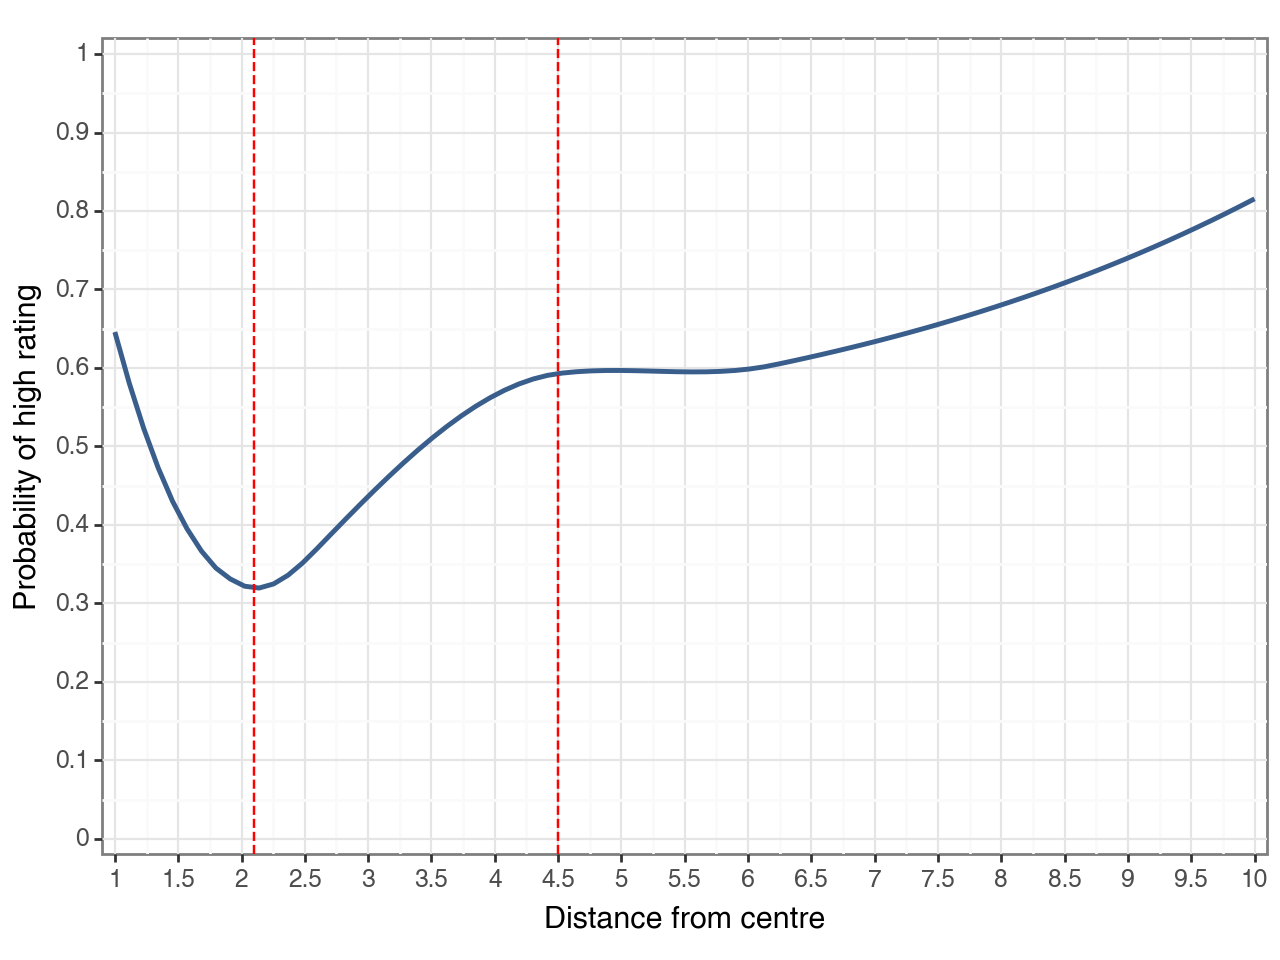

<Figure Size: (640 x 480)>

In [36]:
g2b = (
    ggplot(data=filtered_milan)
    + geom_smooth(
        aes(x="distance", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Distance from centre", y="Probability of high rating "
    )
        + geom_vline(xintercept=2.1, linetype="dashed", color="red") 
    + labs(
        x="Distance from centre", y="Probability of high rating"
    )
        + geom_vline(xintercept=4.5, linetype="dashed", color="red")
    + labs(
        x="Distance from centre", y="Probability of high rating"
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=seq(0, 10, 0.5))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2b

In [37]:
# we can create 3 splines for distance column: knots at 2.1 and 4.5
# -include distance as a piecewise linear spline with these knots

---
#  2. PART - LPM MODEL & PREDICTION
--- 

**Model 1**: estimate linear probability model
- Hotels rated equal to or higher than 4.0 (*highly_rated*) as the binary dependent variable 
- Distance from center as explanatory variable (*distance*) with 3 splines:
    - knots at 2.1 and 4.5
- Price of the accomodation as explanatory variable (*price*) with 2 splines:
    - knot at 175

In [38]:
lpm1 = smf.ols("highly_rated ~ stars + lspline(distance, [2.1,4.5]) + lspline(price, [175])", data=filtered_milan).fit(cov_type="HC1")
stargazer = Stargazer([lpm1])

In [39]:
stargazer.covariate_order([
    "stars",
    "lspline(distance, [2.1, 4.5])[0]",
    "lspline(distance, [2.1, 4.5])[1]",
    "lspline(distance, [2.1, 4.5])[2]",
    "lspline(price, [175])[0]",
    "lspline(price, [175])[1]",
])
stargazer.rename_covariates({"distance":"Distance",
                            "stars":"Stars",
                            "lspline(distance, [2.1, 4.5])[0]": "Distance less than 2.1",
                            "lspline(distance, [2.1, 4.5])[1]": "Distance is between 2.1 and 4.5",
                            "lspline(distance, [2.1, 4.5])[2]": "Distance more than 4.5",
                            "lspline(price, [175])[0]": "Price less than 175",
                            "lspline(price, [175])[1]": "Price more than 175"})
stargazer

In [40]:
lpm1.summary(alpha=0.01)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           highly_rated   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     265.3
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          5.68e-279
Time:                        15:27:36   Log-Likelihood:                -1961.9
No. Observations:                3401   AIC:                             3938.
Df Residuals:                    3394   BIC:                             3981.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.005      0.995]
----------------------------------------------------------------------------------------------------
Intercept                           -0.2572      0.050     -5.167      0.000      -0.385      -0.129
stars                                0.2058      0.009     22.995      0.000       0.183       0.229
lspline(distance, [2.1, 4.5])[0]    -0.1192      0.019     -6.387      0.000      -0.167      -0.071
lspline(distance, [2.1, 4.5])[1]     0.0517      0.013      4.129      0.000       0.019       0.084
lspline(distance, [2.1, 4.5])[2]     0.0362      0.007      4.885      0.000       0.017       0.055
lspline(price, [175])[0]             0.0021      0.000      8.588      0.000       0.001       0.003
lspline(price, [175])[1]            -0.0006      0.000     -4.560      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      750.547   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.205
Skew:                          -0.281   Prob(JB):                     2.72e-40
Kurtosis:                       2.015   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model 1**: conditioning on distance and price variables
- coefficient on stars is 0.21 -> comparing hotels that are the same distance from the center and belong to the same price category one star increase means 20.6pp more likelyhood to be highly rated 

-> statistically significant at 1%, 99% CI [0.183,0.229]: we can be 99% confident that the coefficient is different from 0 in the population and it is in the range given by the CI


- coefficient on distance till 2.1 units distance  -0.119 meaning that comparing hotels that are have the same in number of stars and belong to the same price category see 11.9pp point decrease in probability of being highly rated with one km increase in distance. This is also statistically significant at 1%, 99% CI [-0.16,-0.071]

- coefficient on distance from 2.1 kms to 4.5 on the other hand has a positive association. 0.052 meaning that comparing hotels that are have the same in number of stars and belong to the same price category see 5.2pp point increase in probability of being highly rated with one unit of distance increase. This is also statistically significant at 1%, 99% CI [0.019,0.084]

- this trend continues for hotel further than 4.5 units distance from the centre but only with 3.6 point increase. Statistically significant at 1%, 99% CI [0.017,0.055]

- the coefficient on price below 175 EUR/night is 0.002 meaning that comparing hotels that are the same distance from the center and have the same number of stars a 10 EUR/night increase means 2pp more likelyhood to be highly rated. This is also statictically significant at 1%, 99% CI [0.001,0.003]

- for accomodations with price over 175 EUR/night the coefficient changes sign -0.001 while remaining statictically significant 1%, 99% CI [-0.001,-0.000]. This means that a 10 EUR/night increase means 1pp decrase in probability to be highly rated.

In [41]:
filtered_milan["pred_lpm"] = lpm1.predict()
filtered_milan["pred_lpm"].describe().round(4)

count    3401.0000
mean        0.5398
std         0.2507
min        -0.1997
25%         0.3815
50%         0.5909
75%         0.7283
max         1.0943
Name: pred_lpm, dtype: float64

note: min<0, max>1

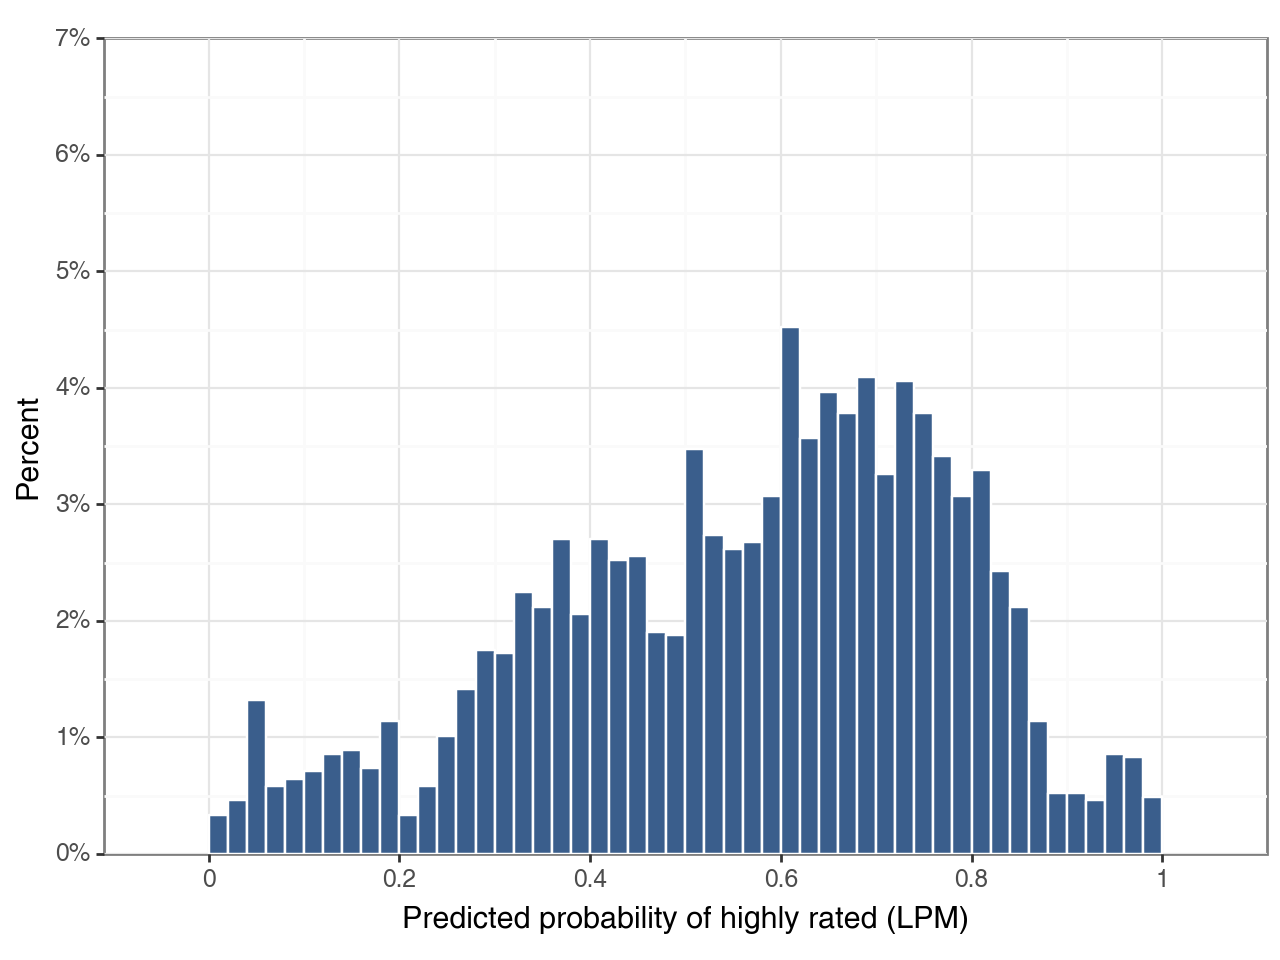

<Figure Size: (640 x 480)>

In [42]:
### Histogram of the predicted probabilities
(
    ggplot(filtered_milan, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill=color[0],
        closed="right",
    )
    + labs(x="Predicted probability of highly rated (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=seq(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + theme_bw()
)

In [43]:
# Characteristics of the hotels in top 1% and bottom 1%:
cuts = 100
filtered_milan["q100_pred_lpm"] = pd.qcut(filtered_milan["pred_lpm"], q=cuts, labels=range(1, cuts + 1))
#qcut() Quantile-based discretization function.
filtered_milan["q100_pred_lpm"]

69902    82
69903    83
69904    83
69905    99
69906    81
         ..
77168    33
77169    31
77170    31
77171    31
77172    31
Name: q100_pred_lpm, Length: 3401, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

In [44]:
filtered_milan.loc[
    filtered_milan["q100_pred_lpm"] == 1,
    ["distance","stars","price"]
].describe().round(1)

# Bottom 1%

,distance,stars,price
count,36.0,36.0,36.0
mean,2.3,1.0,57.3
std,0.2,0.0,10.2
min,1.7,1.0,42.0
25%,2.1,1.0,50.0
50%,2.4,1.0,56.5
75%,2.4,1.0,67.0
max,2.4,1.0,74.0


- av 2.3 kms from center
- all have 1 star
- av price 57.3 EUR/night

In [45]:
filtered_milan.loc[
    filtered_milan["q100_pred_lpm"] == 100,
    ["distance","stars","price"]
].describe().round(1)

# Top 1%

,distance,stars,price
count,34.0,34.0,34.0
mean,0.7,5.0,249.6
std,0.3,0.0,40.6
min,0.1,5.0,172.0
25%,0.5,5.0,228.8
50%,0.8,5.0,243.0
75%,0.9,5.0,283.0
max,1.0,5.0,313.0


- av 0.7 kms from center
- all have 5 stars
- av price 249.6 EUR/night

---
#  3. PART - Logit & Probit Models
--- 

## Logit Model

In [46]:
formula = "highly_rated ~ stars + lspline(distance, [2.1,4.5]) + lspline(price, [175])"
logit = smf.logit(formula, filtered_milan).fit()
table = Stargazer([logit])
table.covariate_order(
    [
    "Intercept","stars",
    "lspline(distance, [2.1, 4.5])[0]",
    "lspline(distance, [2.1, 4.5])[1]",
    "lspline(distance, [2.1, 4.5])[2]",
    "lspline(price, [175])[0]",
    "lspline(price, [175])[1]"
    ]
)
table.rename_covariates({"Intercept": "Constant",
                            "distance":"Distance",
                            "stars":"Stars",
                            "lspline(distance, [2.1, 4.5])[0]": "Distance less than 2.1",
                            "lspline(distance, [2.1, 4.5])[1]": "Distance is between 2.1 and 4.5",
                            "lspline(distance, [2.1, 4.5])[2]": "Distance more than 4.5",
                            "lspline(price, [175])[0]": "Price less than 175",
                            "lspline(price, [175])[1]": "Price more than 175"})
table

Optimization terminated successfully.
         Current function value: 0.545351
         Iterations 6


In [47]:
logit_marginal = logit.get_margeff().summary(alpha=0.01)
logit_marginal

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
====================================================================================================
                                      dy/dx    std err          z      P>|z|      [0.005      0.995]
----------------------------------------------------------------------------------------------------
stars                                0.2115      0.009     23.318      0.000       0.188       0.235
lspline(distance, [2.1, 4.5])[0]    -0.1098      0.019     -5.885      0.000      -0.158      -0.062
lspline(distance, [2.1, 4.5])[1]     0.0457      0.011      4.032      0.000       0.017       0.075
lspline(distance, [2.1, 4.5])[2]     0.0325      0.007      4.388      0.000       0.013       0.052
lspline(price, [175])[0]             0.0019      0.000      7.972      0.000       0.001       0.003
lspline(price, [175])[1]            -0.0005      0.000     -4.427      0.000      -0.001      -0.000
====================================================================================================
"""

Interpretations for the logit model remain the same, also all coefficients are statistically significant at 1%, 99% CI

Coefficients change slighlty:

- stars 20.6 -> 21.15
- dist1 -11.9 -> -10.98
- dist2 5.2 -> -4.47
- dist3 3.6 -> 3.25
- price1 0.21 -> 0.19
- price2 -0.06 -> -0.05

In [48]:
filtered_milan["pred_logit"] = logit.predict()
filtered_milan["pred_logit"].describe()

count    3401.000000
mean        0.539841
std         0.254505
min         0.020499
25%         0.329650
50%         0.599628
75%         0.758088
max         0.957664
Name: pred_logit, dtype: float64

Predicted values probit is bound between 0 and 1 as expected. 0.02 and 0.95

In [49]:
# Characteristics of the hotels in top 1% and bottom 1%:
cuts = 100
filtered_milan["q100_pred_logit"] = pd.qcut(filtered_milan["pred_logit"], q=cuts, labels=range(1, cuts + 1))
#qcut() Quantile-based discretization function.
filtered_milan["q100_pred_logit"]

69902    81
69903    82
69904    82
69905    98
69906    79
         ..
77168    32
77169    31
77170    31
77171    31
77172    31
Name: q100_pred_logit, Length: 3401, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

In [59]:
filtered_milan.loc[
    filtered_milan["q100_pred_logit"] == 1,
    ["distance","stars","price"]
].describe().round(1)

# Bottom 1%

,distance,stars,price
count,36.0,36.0,36.0
mean,2.3,1.0,57.3
std,0.2,0.0,10.2
min,1.7,1.0,42.0
25%,2.1,1.0,50.0
50%,2.4,1.0,56.5
75%,2.4,1.0,67.0
max,2.4,1.0,74.0


In [60]:
filtered_milan.loc[
    filtered_milan["q100_pred_logit"] == 100,
    ["distance","stars","price"]
].describe().round(1)

# Top 1%

,distance,stars,price
count,34.0,34.0,34.0
mean,0.7,5.0,249.6
std,0.3,0.0,40.6
min,0.1,5.0,172.0
25%,0.5,5.0,228.8
50%,0.8,5.0,243.0
75%,0.9,5.0,283.0
max,1.0,5.0,313.0


same interpretation as LPM

## Probit

In [50]:
probit = smf.probit(formula, filtered_milan).fit()
table = Stargazer([probit])
table.covariate_order(
    [
    "Intercept","stars",
    "lspline(distance, [2.1, 4.5])[0]",
    "lspline(distance, [2.1, 4.5])[1]",
    "lspline(distance, [2.1, 4.5])[2]",
    "lspline(price, [175])[0]",
    "lspline(price, [175])[1]"
    ]
)
table.rename_covariates({"Intercept": "Constant",
                            "distance":"Distance",
                            "stars":"Stars",
                            "lspline(distance, [2.1, 4.5])[0]": "Distance less than 2.1",
                            "lspline(distance, [2.1, 4.5])[1]": "Distance is between 2.1 and 4.5",
                            "lspline(distance, [2.1, 4.5])[2]": "Distance more than 4.5",
                            "lspline(price, [175])[0]": "Price less than 175",
                            "lspline(price, [175])[1]": "Price more than 175"})
table

Optimization terminated successfully.
         Current function value: 0.547227
         Iterations 5


In [51]:
probit_marginal = probit.get_margeff().summary()
probit_marginal

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
====================================================================================================
                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
stars                                0.2052      0.009     23.151      0.000       0.188       0.223
lspline(distance, [2.1, 4.5])[0]    -0.1087      0.019     -5.793      0.000      -0.145      -0.072
lspline(distance, [2.1, 4.5])[1]     0.0449      0.012      3.884      0.000       0.022       0.068
lspline(distance, [2.1, 4.5])[2]     0.0343      0.007      4.579      0.000       0.020       0.049
lspline(price, [175])[0]             0.0020      0.000      8.211      0.000       0.002       0.002
lspline(price, [175])[1]            -0.0005      0.000     -4.685      0.000      -0.001      -0.000
====================================================================================================
"""

Interpretations for the probit model remain the same, also all coefficients are statistically significant at 1%, 99% CI

Coefficients change slighlty:

- stars 20.6 -> 21.15 -> 20.52
- dist1 -11.9 -> -10.98 -> -10.87
- dist2 5.2 -> -4.47 -> 4.49
- dist3 3.6 -> 3.25 -> 3.43
- price1 0.21 -> 0.19 -> 0.2
- price2 -0.06 -> -0.05 -> -0.05

In [52]:
filtered_milan["pred_probit"] = probit.predict()
filtered_milan["pred_probit"].describe()

count    3401.000000
mean        0.539725
std         0.249549
min         0.012741
25%         0.343134
50%         0.596547
75%         0.748964
max         0.965363
Name: pred_probit, dtype: float64

Predicted values probit is bound between 0 and 1 as expected.
0.01 and 0.96

(narrower than for LPM, range -0.19 to 1.09, thanks to the nonlinear form)

---
#  4. PART - GOODNESS OF FIT
--- 

LPM (predicted values from LPM with many covariates)

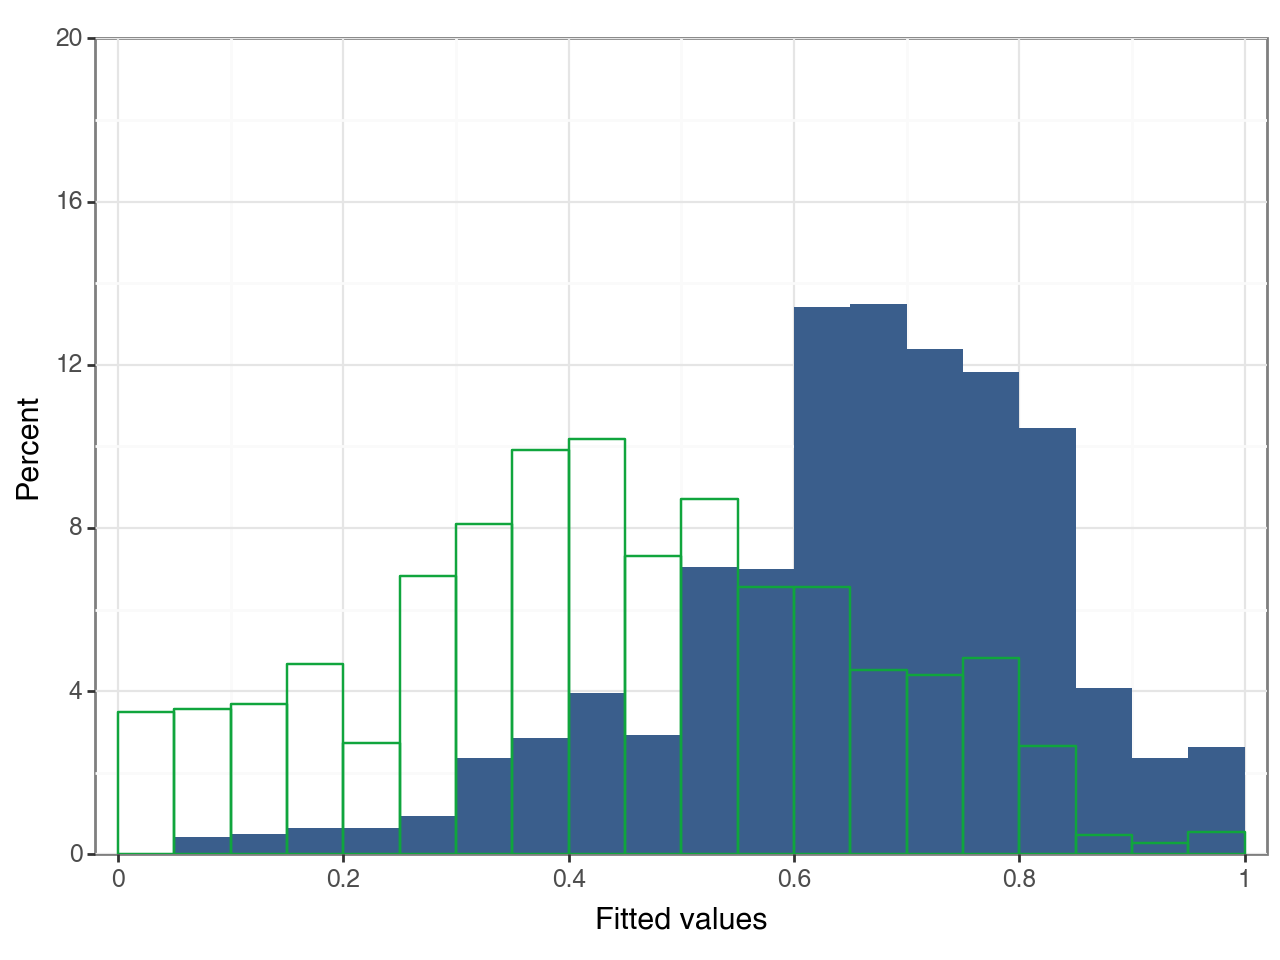

<Figure Size: (640 x 480)>

In [53]:
(
    ggplot(
        filtered_milan,
        aes(x="pred_lpm", fill="highly_rated", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        filtered_milan[filtered_milan["highly_rated"] == 1],
        binwidth=0.05,
        # color="blue",
        fill=color[0],
        boundary=0.55,
    )
    + geom_histogram(
        filtered_milan[filtered_milan["highly_rated"] == 0],
        binwidth=0.05,
        color=color[1],
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 20], breaks=seq(0, 21, 4))
    + theme_bw()
)

This prediction is very far from producting perfect fit (which would correspond to no overlap)

#### Comparing probability models – mean and median

The more different these statistics are between y=0 and y=1 groups, the better the fit of the probability model

In [54]:
filtered_milan.groupby("highly_rated")[
    ["pred_lpm", "pred_logit", "pred_probit"
]].mean().round(3)

,pred_lpm,pred_logit,pred_probit
highly_rated,,,
0,0.403,0.396,0.400
1,0.656,0.662,0.659


In [55]:
filtered_milan.groupby("highly_rated")[[
    "pred_lpm", "pred_logit", "pred_probit"
]].median().round(3)

,pred_lpm,pred_logit,pred_probit
highly_rated,,,
0,0.413,0.366,0.381
1,0.677,0.710,0.701


Logit seems to be the best fit slightly ahead of probit and both logit and probit being better than lpm

In [56]:
pd.DataFrame(
    {
        "R-squared": [
            lpm1.rsquared,
            r2_score(filtered_milan["highly_rated"], filtered_milan["pred_logit"]),
            r2_score(filtered_milan["highly_rated"], filtered_milan["pred_probit"]),
        ],   
        "Brier-score": [
            mean_squared_error(filtered_milan["highly_rated"], filtered_milan["pred_lpm"]),
            mean_squared_error(filtered_milan["highly_rated"], filtered_milan["pred_logit"]),
            mean_squared_error(filtered_milan["highly_rated"], filtered_milan["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit.prsquared, probit.prsquared],
        "Log-loss": [
            -1 * log_loss(filtered_milan["highly_rated"], filtered_milan["pred_lpm"]),
            -1 * log_loss(filtered_milan["highly_rated"], filtered_milan["pred_logit"]),
            -1 * log_loss(filtered_milan["highly_rated"], filtered_milan["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)

,LPM,Logit,Probit
R-squared,0.253,0.272,0.269
Brier-score,0.186,0.181,0.182
Pseudo R-squared,NaN,0.210,0.207
Log-loss,-0.756,-0.545,-0.547


The ranking stays the same:
- Logit and probit provide predictions of almost the same quality, with logit being a slightly better fit, and both better than LPM
- but small differences (still better to use logit and probit)

In [57]:
df_plot = pd.melt(
    filtered_milan[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)


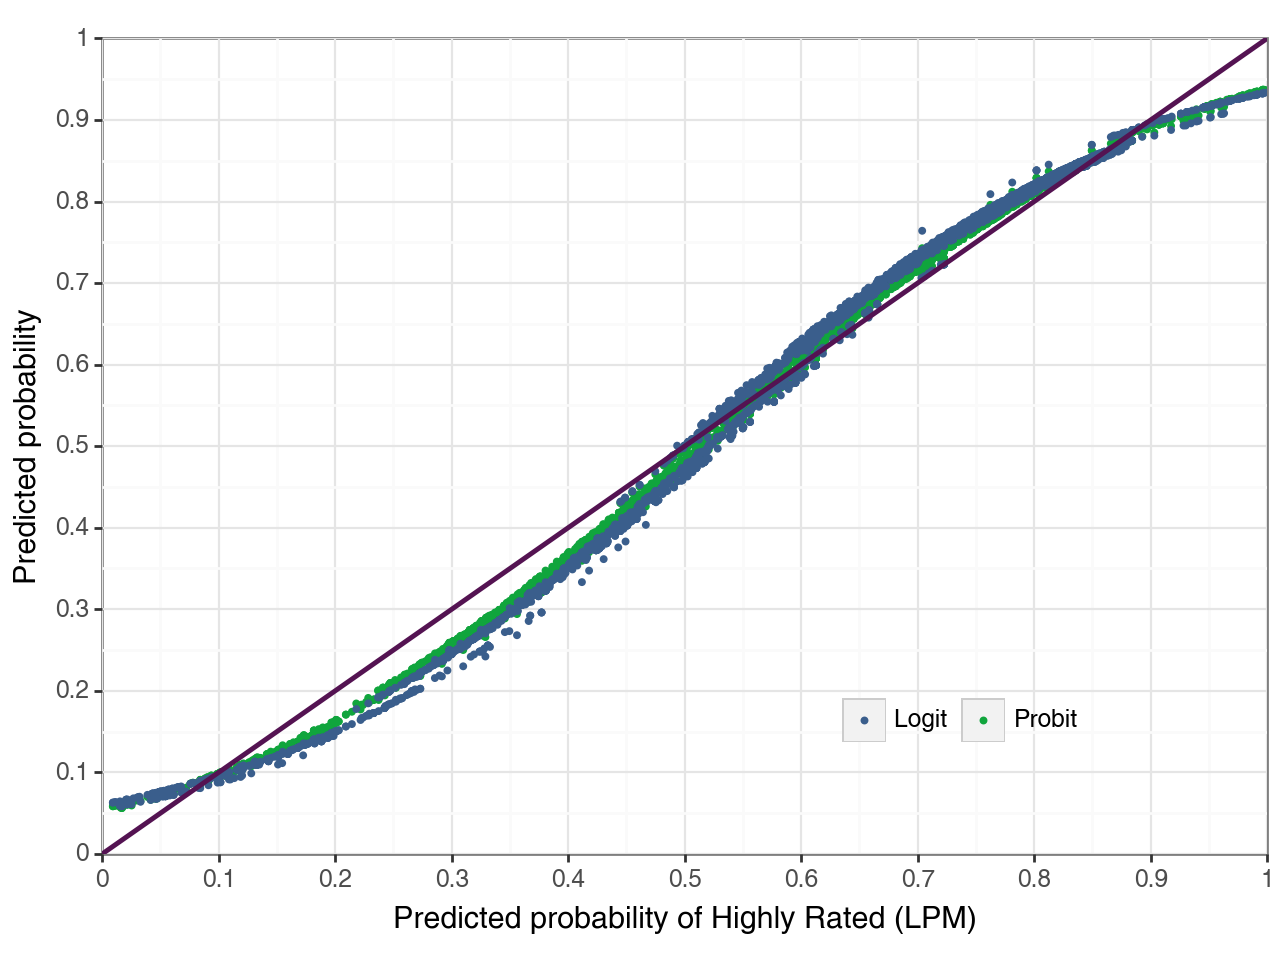

<Figure Size: (640 x 480)>

In [58]:
g5 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of Highly Rated (LPM)", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=seq(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g5

- Logit and probit slighlty different
- different from the 45 degree line 
- at tails: logit and probit predicted probabilities are less extreme (less close to zero, or less close to 1)

- we can choose either logit or probit
- LPM different from logit and probit
- LPM is not restricted to generate predicted probabilities between 0 and 1

Conclusions: 
1. Milanese accomodations are more likely to be highly rated with higher number of stars with the same distance from the center and within the same price category
 > 20pp difference per unit increase
 > statistically significant
 
2. The probability of an accomodation in Milan being highly rated first decreases with higher distance from the center then increases with the increase of distance
 > statistically significant
 
3. First, with the increase of the nighlty price the probability of being highly rated increases then it starts to decrease for accommodations in Milan
 > the top 1% of the predicted highly rated accommodations has a mean price of 250 EUR/night even though the maximum price in the filtered dataset is 550 EUR/night
 > 
 >statistically significant